In [6]:
!pip install spotipy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 20.3 MB/s eta 0:00:00


In [23]:
import networkx as nx
import pandas as pd

# ------- IMPLEMENT HERE ANY AUXILIARY FUNCTIONS NEEDED ------- #
import spotipy
from spotipy . oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt

import requests
import networkx as nx
import matplotlib.pyplot as plt

In [24]:
client_id = "84d2340210f14b8da88fb64ad85b6ea0"
client_secret = "d436436448a2482da40af7b6a045f86a"
auth_manager = SpotifyClientCredentials(client_id = client_id, client_secret = client_secret)
sp = spotipy.Spotify(auth_manager = auth_manager)

In [26]:
def search_artist(artist_name: str) -> str:
    """
    Search for an artist in Spotify.

    :param artist_name: name to search for.
    :return: spotify artist id.
    """
    # ------- IMPLEMENT HERE THE BODY OF THE FUNCTION ------- #
    
    results = sp.search(q=artist_name, type='artist')
    artist_id = results['artists']['items'][0]['id']
    return artist_id
    
    # ----------------- END OF FUNCTION --------------------- #

Note: The 3 following functions are externally obtained and accordingly modified, explanations on report.

Obtener token de acceso de Spotify:

Esta función se encarga de hacer una solicitud a la API de Spotify para obtener un token de acceso válido. El token de acceso es necesario para realizar solicitudes a la API en nombre del cliente.

In [ ]:

def get_access_token(client_id, client_secret):
    auth_url = 'https://accounts.spotify.com/api/token'
    payload = {'grant_type': 'client_credentials'}
    response = requests.post(auth_url, auth=(client_id, client_secret), data=payload)
    access_token = response.json()['access_token']
    return access_token


Obtener géneros de un artista:

Esta función toma como entrada el ID de un artista y el token de acceso, y realiza una solicitud a la API de Spotify para obtener los géneros asociados con ese artista.

In [ ]:

def get_artist_genres(artist_id, access_token):
    headers = {'Authorization': f'Bearer {access_token}'}
    artist_url = f'https://api.spotify.com/v1/artists/{artist_id}'
    response = requests.get(artist_url, headers=headers)
    artist_data = response.json()
    genres = artist_data.get('genres', [])
    return genres

Obtener información de lanzamientos de un artista:

Esta función toma como entrada el ID de un artista y el token de acceso, y realiza una solicitud a la API de Spotify para obtener información sobre los lanzamientos (álbumes) asociados con ese artista.

In [ ]:

def get_artist_releases(artist_id, access_token):
    headers = {'Authorization': f'Bearer {access_token}'}
    releases_url = f'https://api.spotify.com/v1/artists/{artist_id}/albums'
    response = requests.get(releases_url, headers=headers)
    releases = response.json().get('items', [])
    return releases

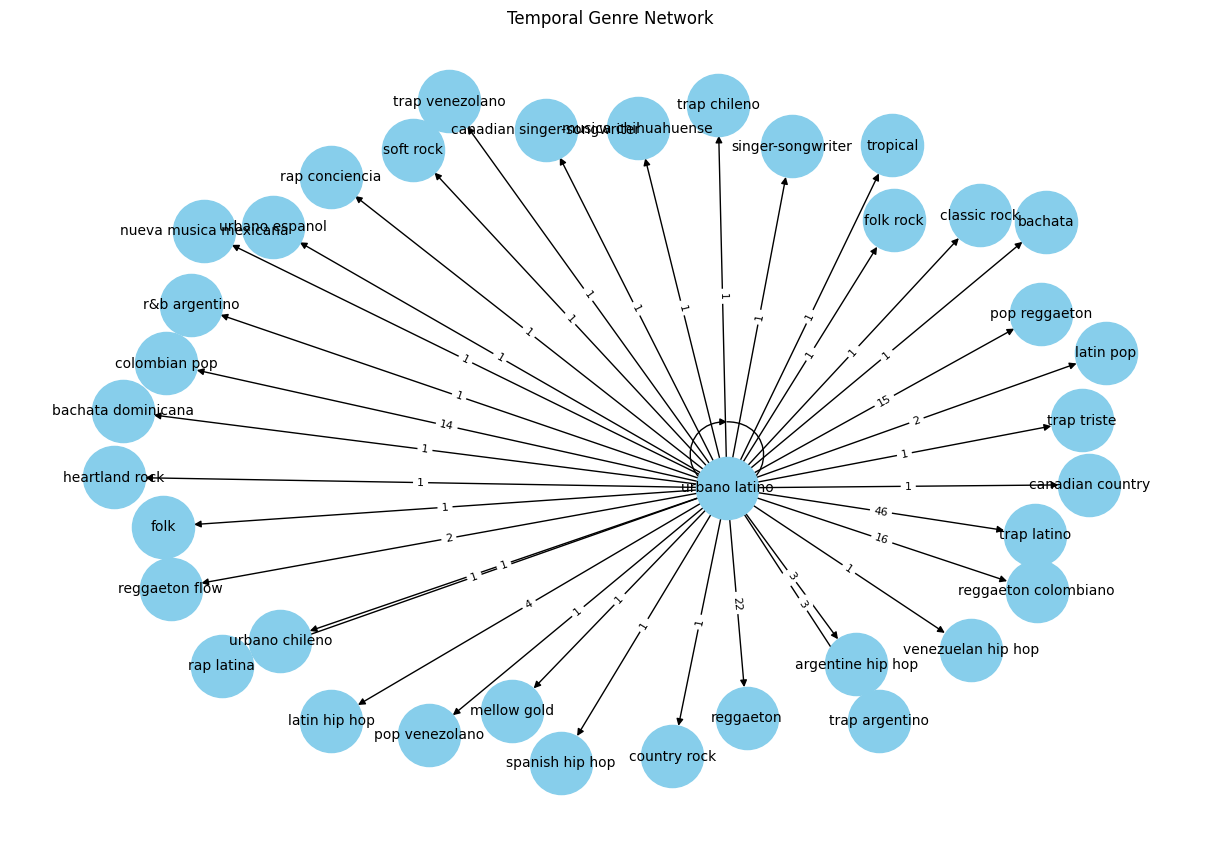

In [29]:
# Create a temporal network of genres
def create_genre_network(artist_ids, access_token):
    # Create a directed graph to represent the network
    G = nx.DiGraph()

    for artist_id in artist_ids:
        # Get the genres of the current artist
        genres = get_artist_genres(artist_id, access_token)
        # Get the releases (albums) of the current artist
        releases = get_artist_releases(artist_id, access_token)
        # Sort the releases by release date
        sorted_releases = sorted(releases, key=lambda x: x.get('release_date'))

        for i in range(len(sorted_releases) - 1):
            # Get the genres of the current release
            current_genres = genres
            # Get the next artist's ID based on the next release
            next_artist_id = search_artist(sorted_releases[i + 1]['artists'][0]['name'])
            # Get the genres of the next artist
            next_genres = get_artist_genres(next_artist_id, access_token)

            for genre in current_genres:
                # Add the current genre as a node in the graph
                G.add_node(genre)

            for next_genre in next_genres:
                if G.has_edge(genre, next_genre):
                    # If the edge already exists, increase its weight by 1
                    G[genre][next_genre]['weight'] += 1
                else:
                    # If the edge doesn't exist, add it with a weight of 1
                    G.add_edge(genre, next_genre, weight=1)

    return G

# Visualize the temporal network of genres
def visualize_genre_network(G):
    # Set the figure size
    plt.figure(figsize=(12, 8))
    # Determine the positions of the nodes using the spring layout algorithm
    pos = nx.spring_layout(G)
    # Get the edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    # Draw the graph with nodes, labels, colors, sizes, and font sizes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10)
    # Add labels to the edges
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    # Set the title of the plot
    plt.title('Temporal Genre Network')
    # Display the plot
    plt.show()

# Obtain access to the Spotify API
access_token = get_access_token(client_id, client_secret)

# Example list of artists (replace with your own artist names)
artist_names = ['Feid', 'Mora', 'Bad Bunny']

# Search for artist IDs
artist_ids = [search_artist(name) for name in artist_names]

# Create the temporal network of genres
genre_network = create_genre_network(artist_ids, access_token)

# Visualize the temporal network of genres
visualize_genre_network(genre_network)



In [32]:
order_nt = len(genre_network.nodes)
size_nt = len(genre_network.edges)

print('Order network:', order_nt)
print('Size network:', size_nt)

Order network: 37
Size network: 37


In [31]:
nx.write_gexf(genre_network, 'genre_network.gexf')